In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                     as tf
import numpy                                  as np
import seaborn                                as sns
import pandas                                 as pd
import numpy.random                           as random
from sklearn.utils                        import shuffle
from sklearn.model_selection              import train_test_split
from tqdm                                 import tqdm
from os                                   import path
import pysftp                                 as sftp

LocalFlg         = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib                             as mpl
import matplotlib.pyplot                      as plt
plt.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')

import random                                 as rnd

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [65]:
SurQCTFldr          = WORKSPACE_PATH + '/SurQCT/surqct/'

RatesType           = 'KDiss'
NNRunIdx            = 55

PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures/' 

TTranVec            = [1500.0, 2500.0, 3000.0, 5000.0, 6000.0, 8000.0, 10000.0, 12000.0, 14000.0, 15000.0, 20000.0]

iIdxVec             = np.array([1, 1000, 2000, 3000, 4000, 4581, 5000, 6000], dtype=int)

In [66]:
#===================================================================================================================================
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)
#===================================================================================================================================


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/


In [67]:
#===================================================================================================================================
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'


[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...


In [68]:
#===================================================================================================================================
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KDiss                     = model(InputData, InputData.PathToRunFld, None, None)
NN_KDiss.load_params(InputData.PathToParamsFld)
#===================================================================================================================================


[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['ECB_i', 'ro_i', 'rMax_i', 'TTran_i']
[SurQCT]:     y =  KDiss
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/MyModel
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/Params//ModelCheckpoint/cp-46260.ckpt


In [69]:
#===================================================================================================================================
OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec           = list(set(xVarsVec_i))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+8
MinValueTrain      = 1.e-18 * InputData.MultFact
MinValueTest       = 1.e-18 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

#InputData.iLevelsVecTest = list(np.array(InputData.iLevelsVecTest) - 1)

[SurQCT]:   Reading Variables:  ['ro', 'vqn', 'ECB', 'rMax', 'jqn']


In [70]:
#===================================================================================================================================
### Reading Levels Info of Initial and Final Molecules
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp


In [71]:
#=======================================================================================================================================
# Reading Excitation Rates Data 
def read_kdissdata(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}
        
    try:
        TStr  = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
        grp   = f[TStr]
        Data  = grp["Diss"]
        KDiss = Data[...]
        f.close()   

    except:    
        KDiss = None
        
    return KDiss
#=======================================================================================================================================

[SurQCT]:    TTran =  1500.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  3000.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 3000K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000.0
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_U

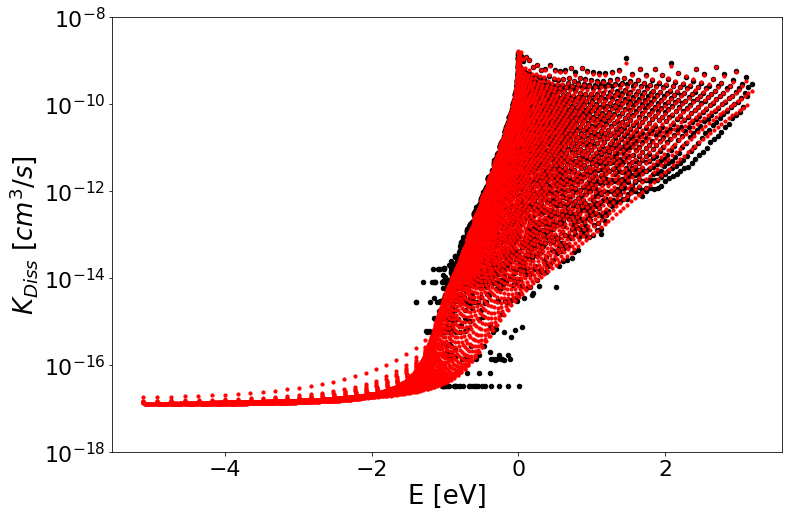

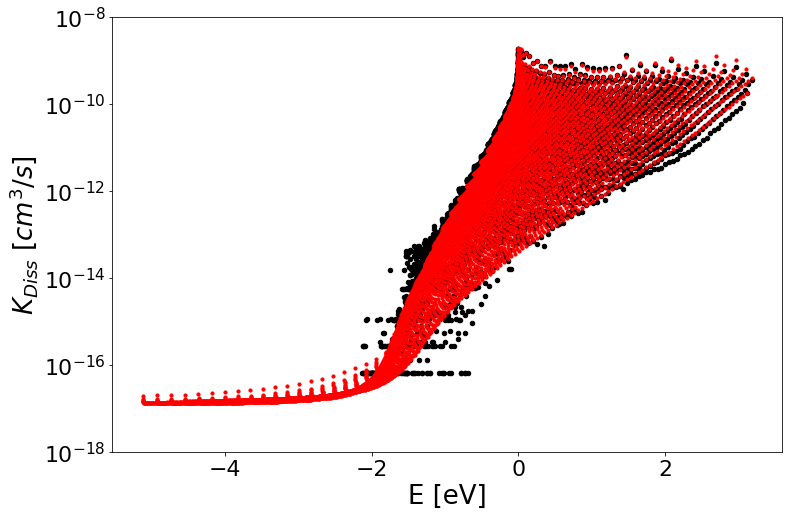

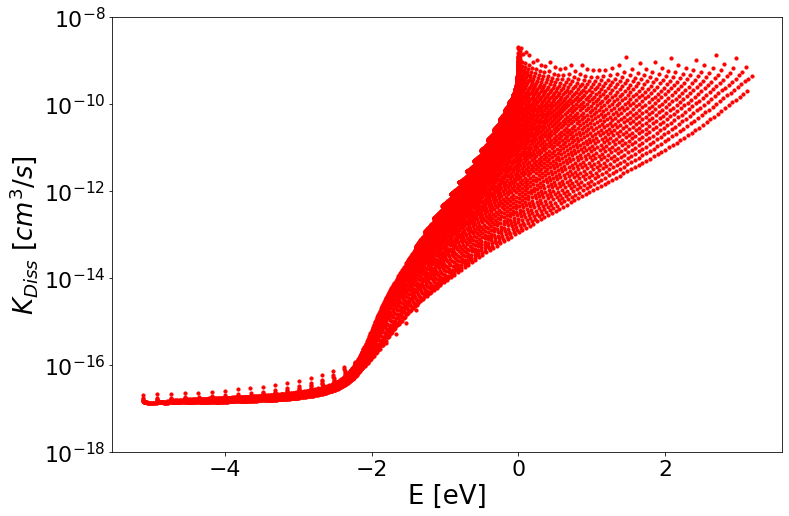

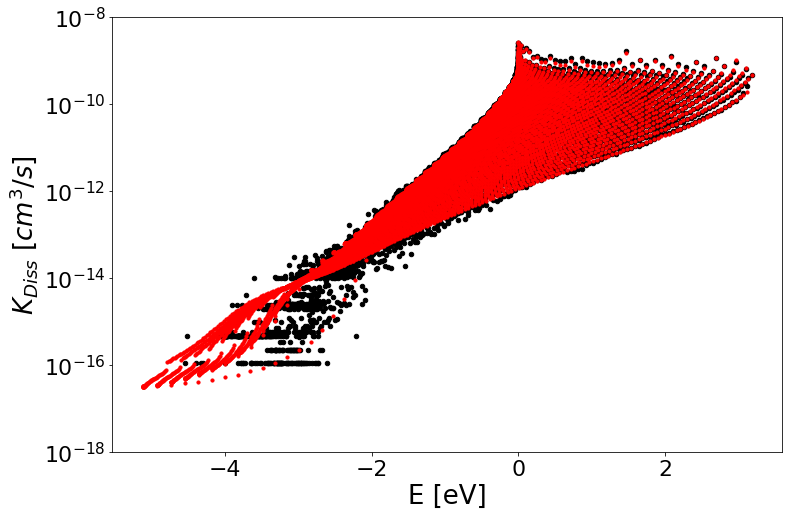

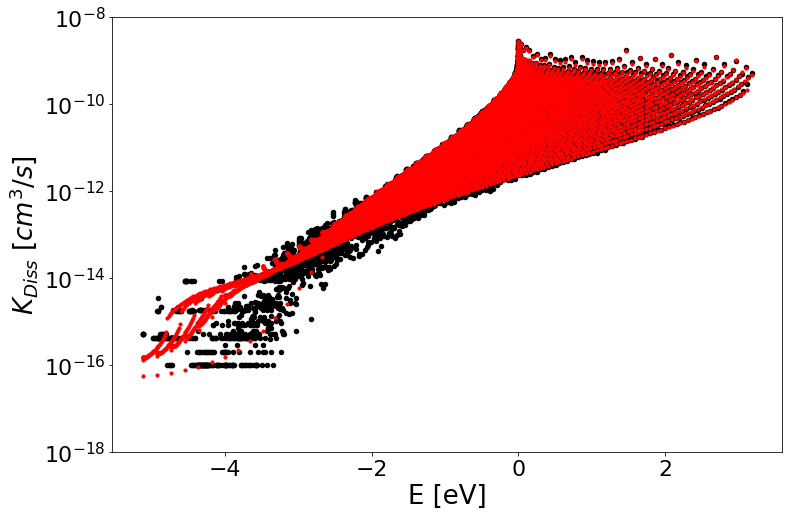

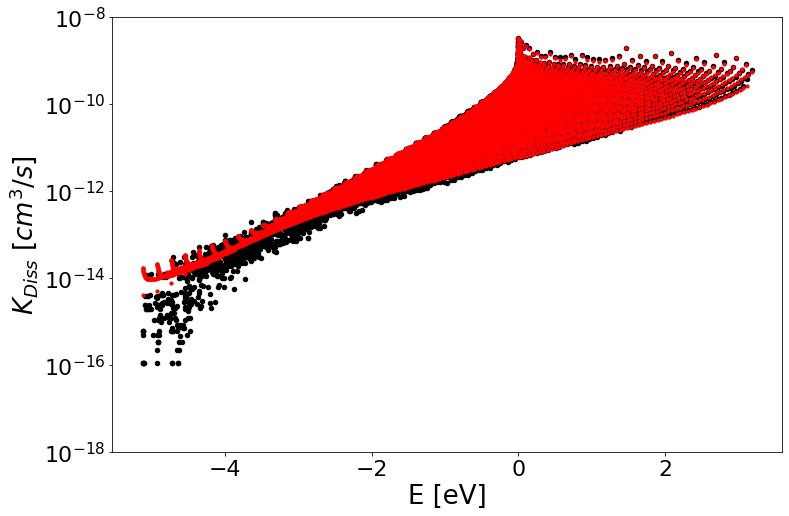

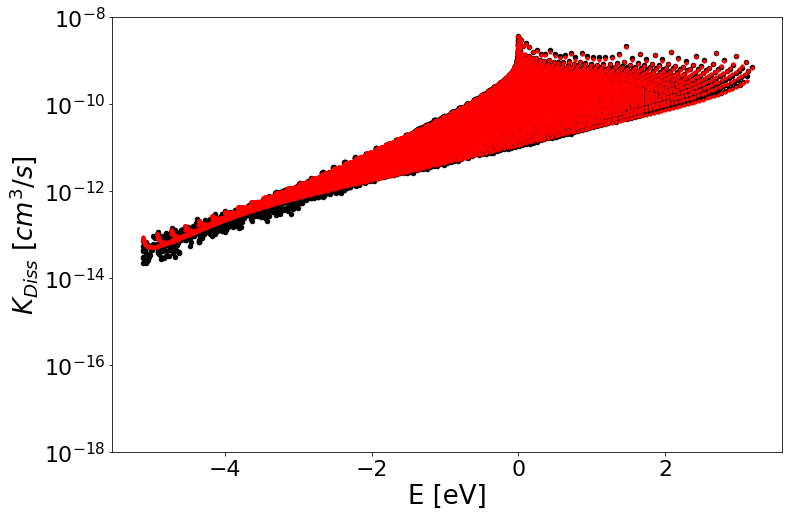

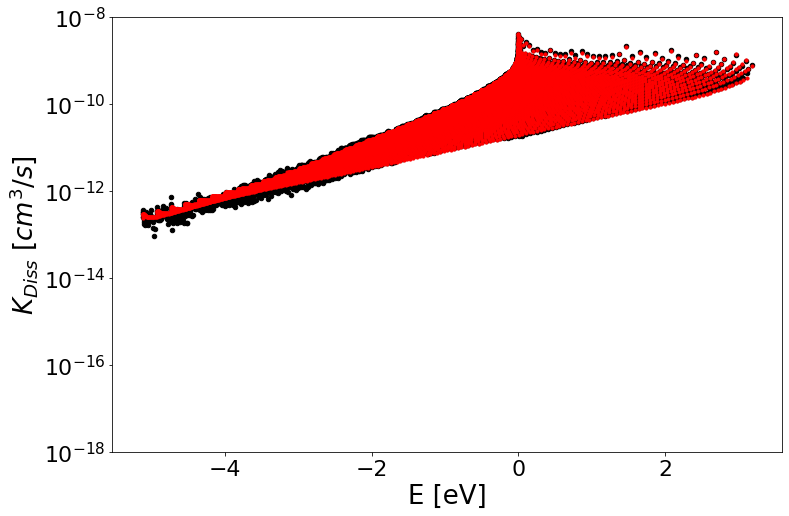

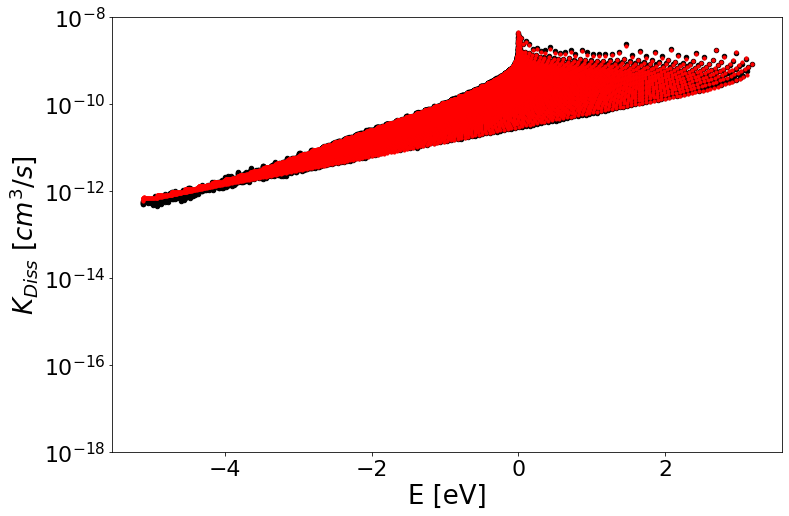

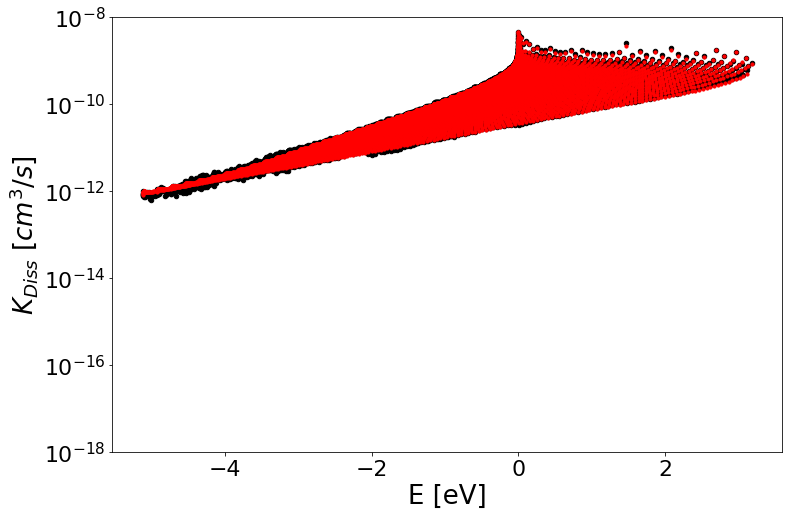

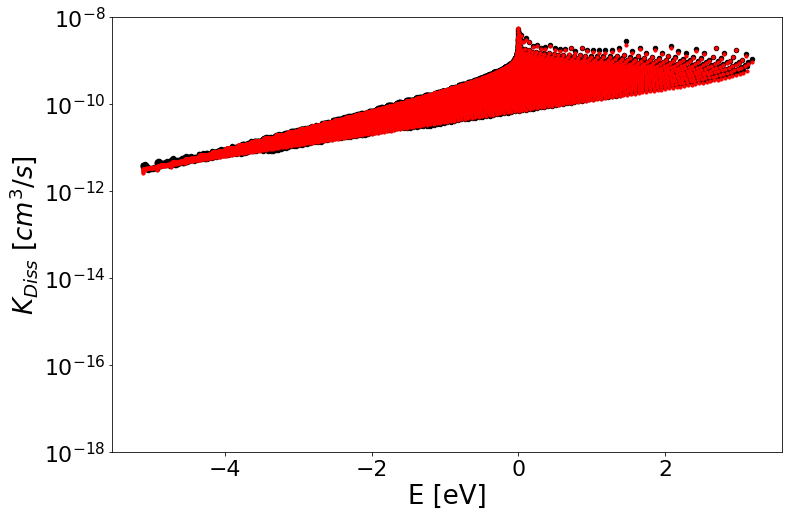

In [72]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-18, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')

[SurQCT]:    TTran =  1500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  3000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 3000K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_D

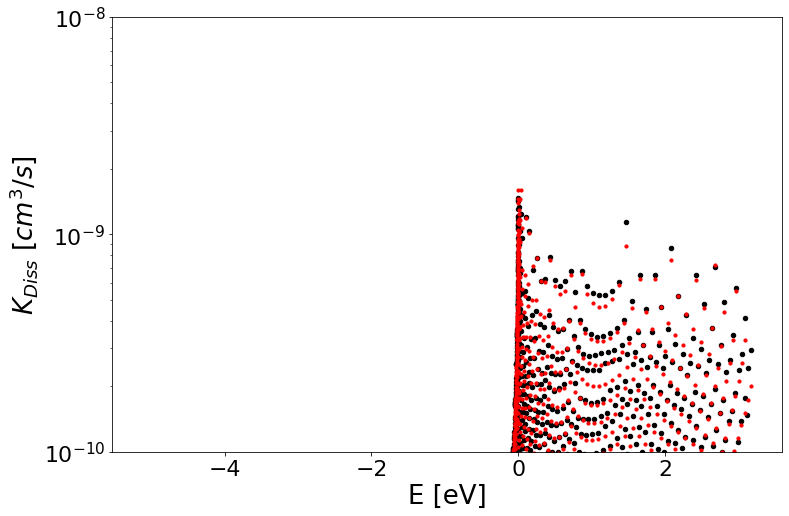

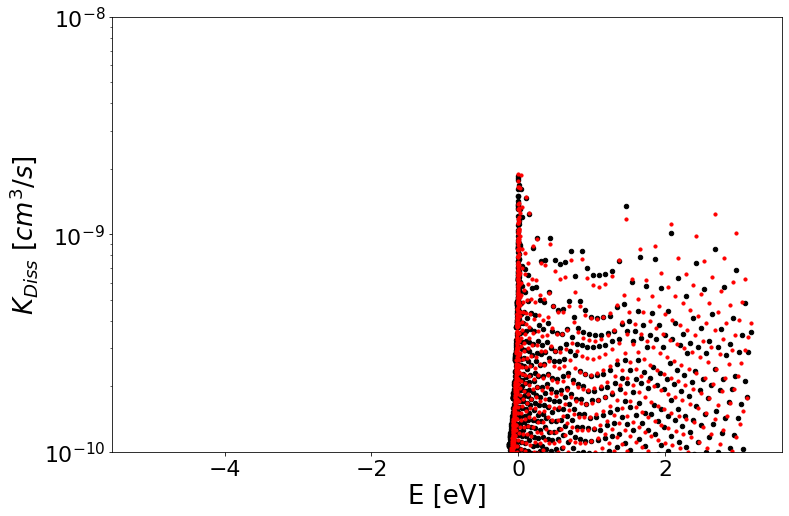

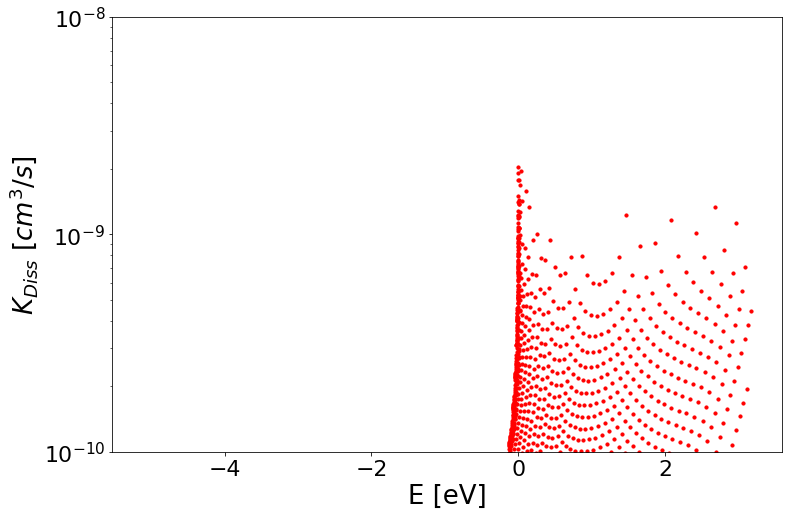

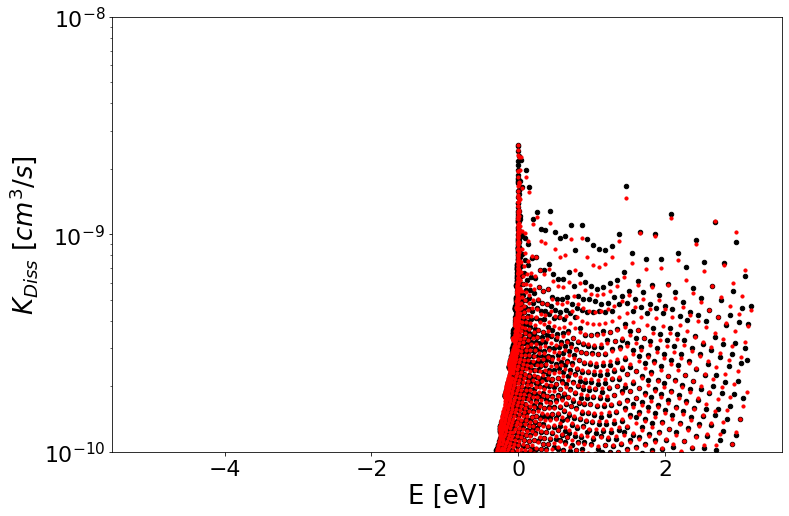

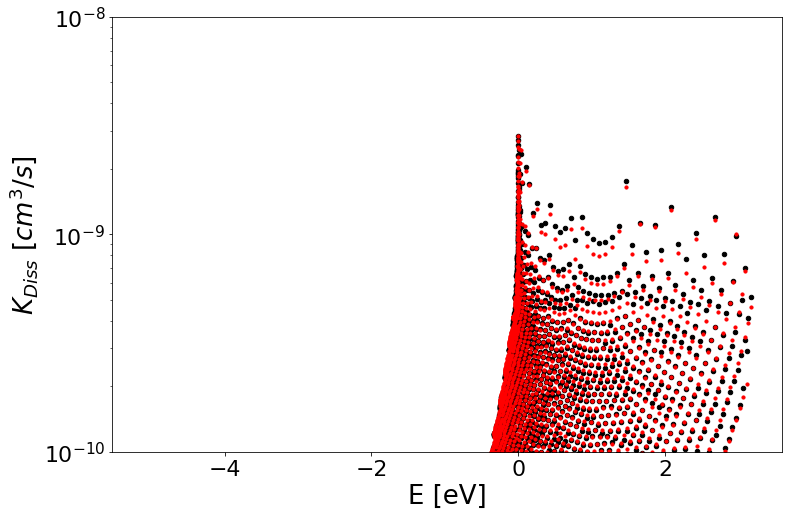

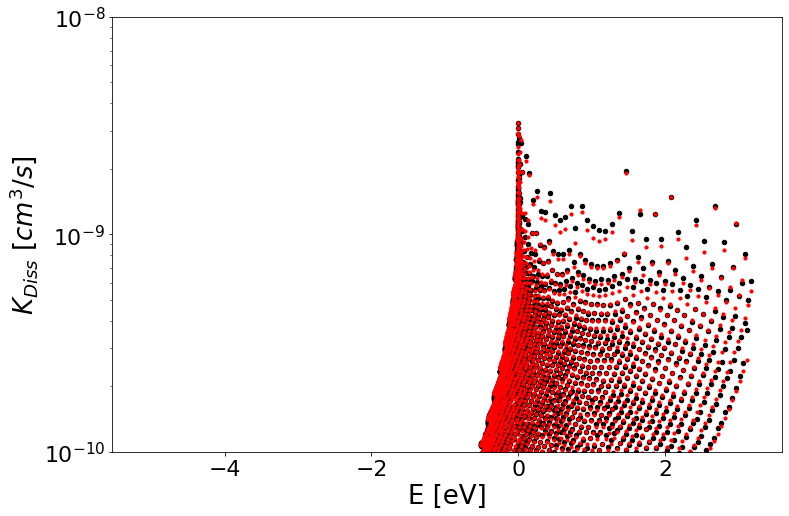

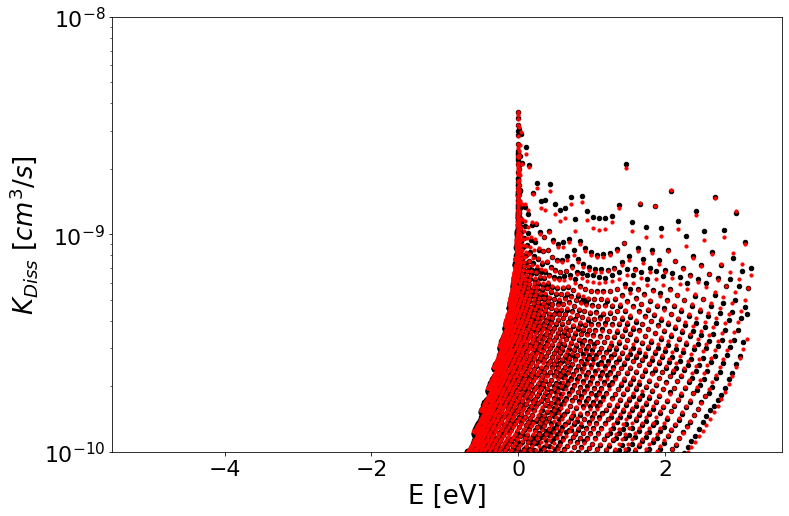

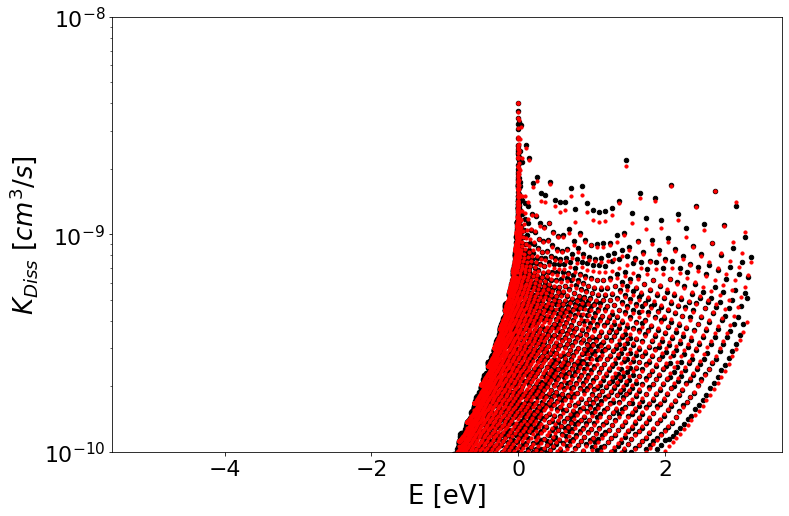

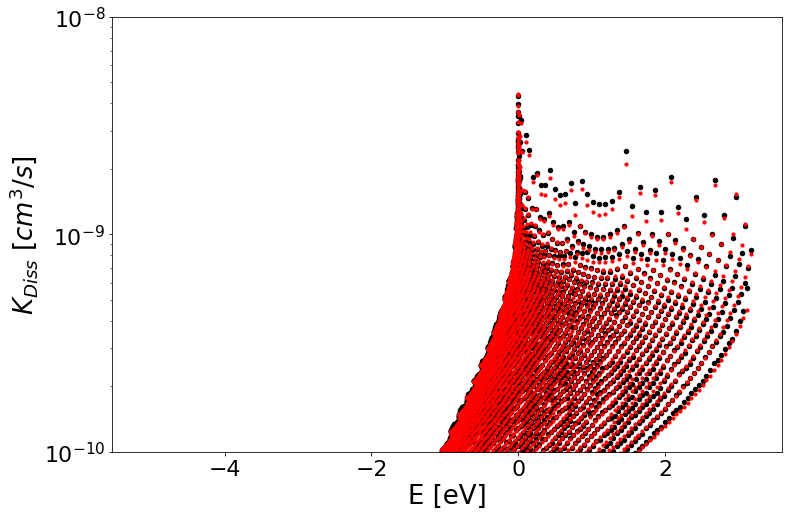

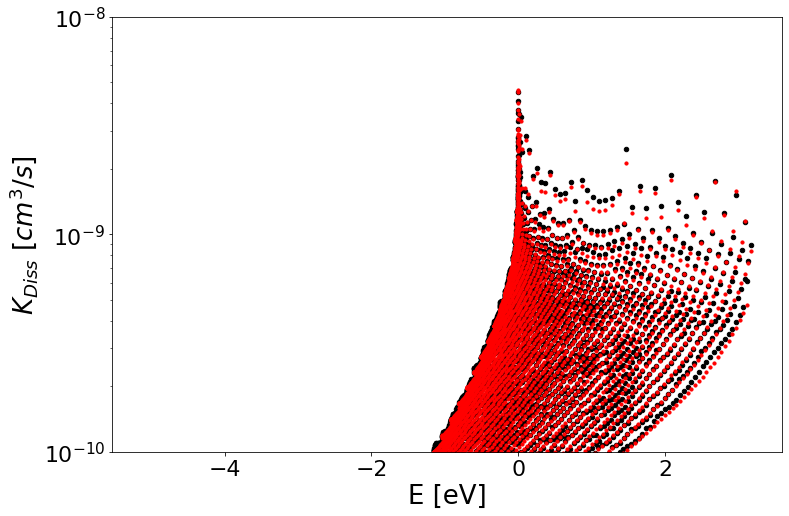

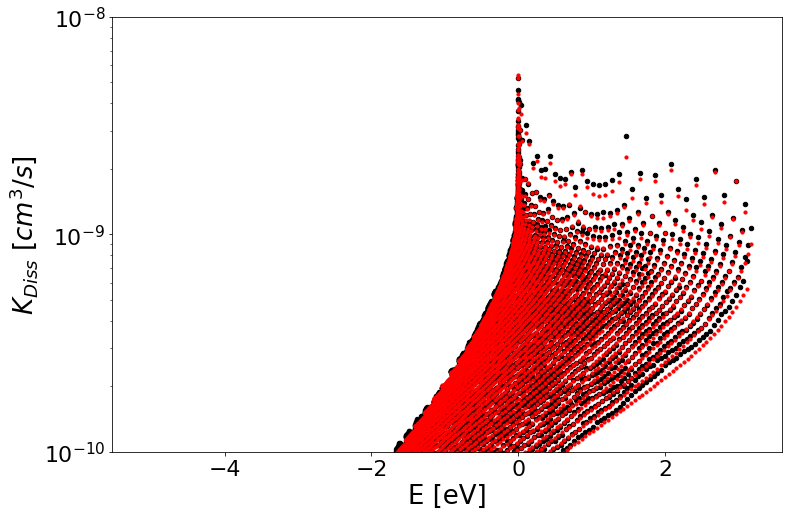

In [29]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-10, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')

In [14]:
TTran = 5000.0
PathToSampledLevels = InputData.PathToSampledLevels + str(int(TTran)) + 'K.csv'
print('[SurQCT]:       Reading Sampled Initial Levels List from File: ' + PathToSampledLevels)

Mask  = pd.read_csv(PathToSampledLevels, header=0)
Mask  = np.squeeze(Mask.to_numpy())
Mask2 = Mask[45:90]

[SurQCT]:       Reading Sampled Initial Levels List from File: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/Active_Sampled/O2_T5000K.csv


In [15]:
Grouping = []
Grouping = pd.read_csv(InputData.PathToGrouping, header=0)
Grouping.columns=['LevelNb','GroupIndex']

In [40]:
# Grouping['GroupIndex'][list(Mask2-1)]

In [41]:
DiatData[0]['jqn'][list(Mask-1)]

In [42]:
# DiatData[0]['jqn'][list(Mask-1)].hist(bins=240)

In [27]:
KDiss = read_kdissdata(InputData, InputData.PathToHAHDF5File, TTran, TTran, 3)

# plt.plot(KDiss[:,0], 'o')
# plt.yscale('log')

[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database_Active/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K


Text(0, 0.5, '$K_{Diss}$ [$cm^3/s$]')

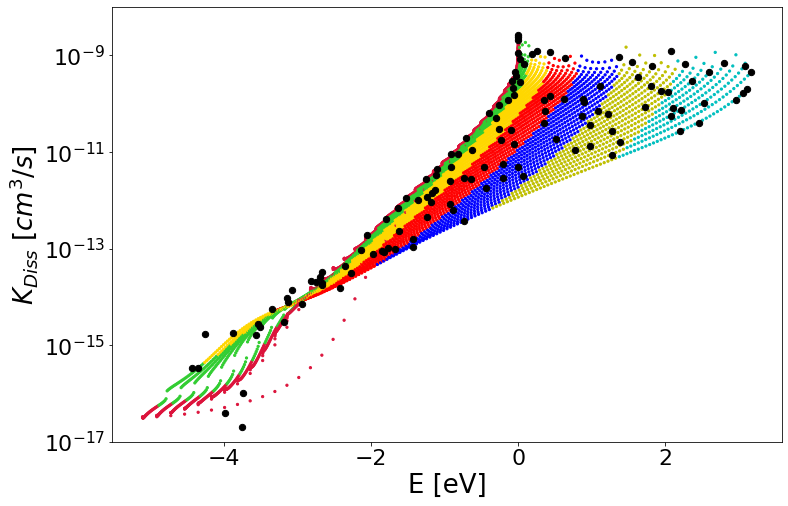

In [64]:
jNLevels              = len(LevelsData[0])    

### FWD Rates
iiIdxVec              = np.arange(jNLevels)

TTranVecNLevels       = np.ones((jNLevels))*TTran
TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNLevels})
TTranDataTemp.index   = iiIdxVec


iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
iLevelsDataTemp.index = iiIdxVec

iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    
    
### Plotting
cmap = mpl.colors.ListedColormap(["crimson","limegreen","gold", "r","b","y","c"])

fig = plt.figure(figsize=(12,8))
scatter = plt.scatter(DiatData[0]['EInt'], KDiss_NN,   s=5, c=(DiatData[0]['jqn']), cmap=cmap)
if (KDiss is not None):
    plt.scatter(DiatData[0]['EInt'], KDiss[:,0], s=40, c='k')
plt.yscale('log')
plt.ylim([1.e-17, 1.e-8])
plt.xlabel('E [eV]')
plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')

#fig.colorbar(scatter)

In [63]:
print(KDiss[list(Mask-1)])
print(Mask[KDiss[list(Mask-1),0]<2.e-16])
print(Mask)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.56703077e-09 1.05689517e-09 1.51013560e-09]
 [4.55636666e-10 1.12204732e-10 3.43431935e-10]
 [1.76693575e-14 9.31613575e-15 8.35322180e-15]
 [9.04937451e-14 2.92013575e-14 6.12923876e-14]
 [2.79366416e-15 6.88105868e-16 2.10555829e-15]
 [6.94592765e-11 9.63246188e-12 5.98268146e-11]
 [6.90814161e-13 2.03954610e-13 4.86859551e-13]
 [2.95683226e-11 6.62381531e-12 2.29445073e-11]
 [1.50076353e-10 4.95974292e-11 1.00478923e-10]
 [2.87991318e-12 3.83132641e-13 2.49678054e-12]
 [1.83545375e-11 2.16619248e-12 1.61883450e-11]
 [1.58804438e-13 4.35083978e-14 1.15296041e-13]
 [2.01195906e-17 2.01195906e-17 0.00000000e+00]
 [2.68618597e-12 6.61773556e-13 2.02441241e-12]
 [2.97832338e-15 8.22266210e-17 2.89609676e-15]
 [7.32711043e-11 5.24913258e-12 6.80219717e-11]
 [1.07295906e-10 1.21763740e-11 9.51195317e-11]
 [1.93609850e-14 2.42949383e-15 1.69314911e-14]
 [2.16710619e-14 2.87909493e-15 1.87919669e-14]
 [7.81460393e-14 1.33044754e-14 6.484156

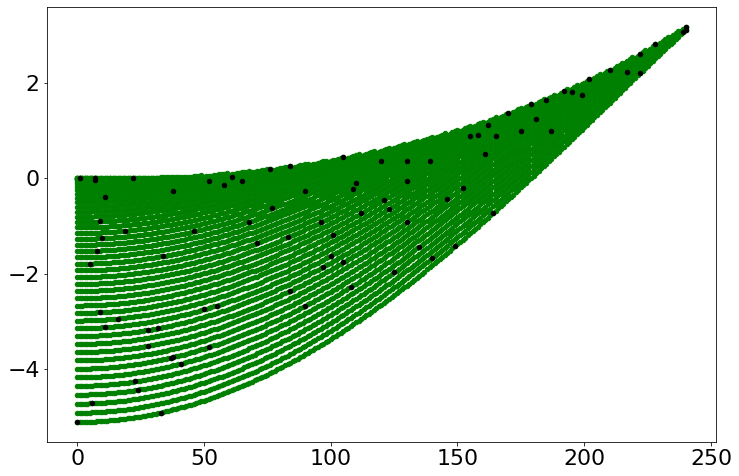

In [34]:
if (KDiss is not None):
    fig = plt.figure(figsize=(12,8))
    plt.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'], s=20, c='g')
    plt.scatter(DiatData[1]['jqn'][Mask-1], DiatData[1]['EInt'][Mask-1], s=20, c='k')

In [10]:
# PathToLevelsFile = InputData.PathToLevelsFile
# PathToDiatFile   = InputData.PathToDiatFile
# Molecules        = InputData.Molecules
# PathToHDF5File   = InputData.PathToHDF5File
# ScalingFact      = 1

PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']
Molecules        = ['N2', 'N2']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/N3_NASA.hdf5'
ScalingFact      = 1


In [11]:
# #===================================================================================================================================
# ### Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

TTranVec

[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp


[2500.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0]

[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  7500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 7500K
[SurQCT]:    TTran =  10000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K
[SurQCT]:    TTran =  15000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 15000K
[SurQCT]:    TTran =  20000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Datab

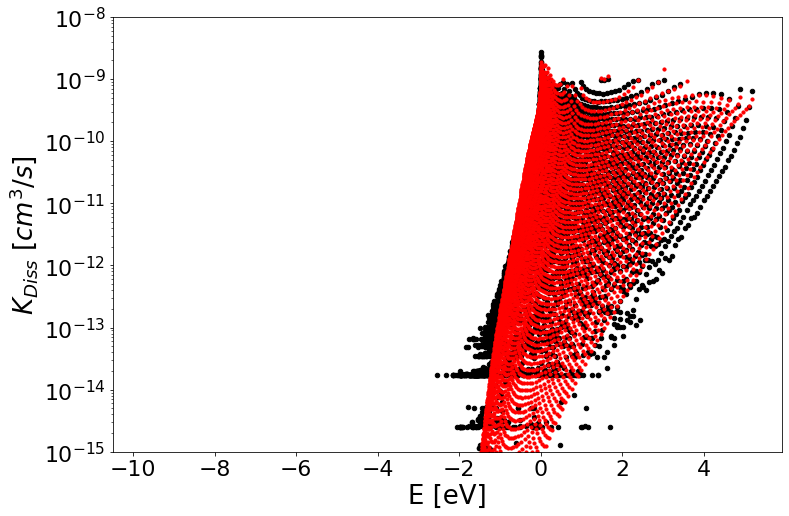

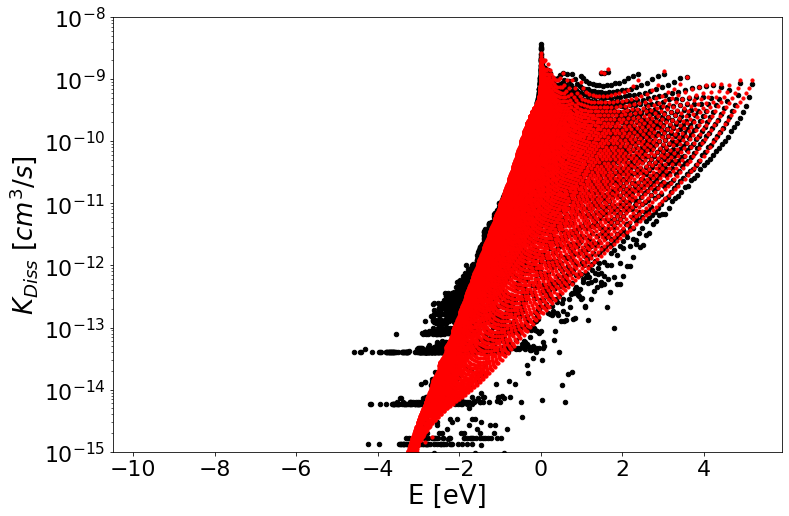

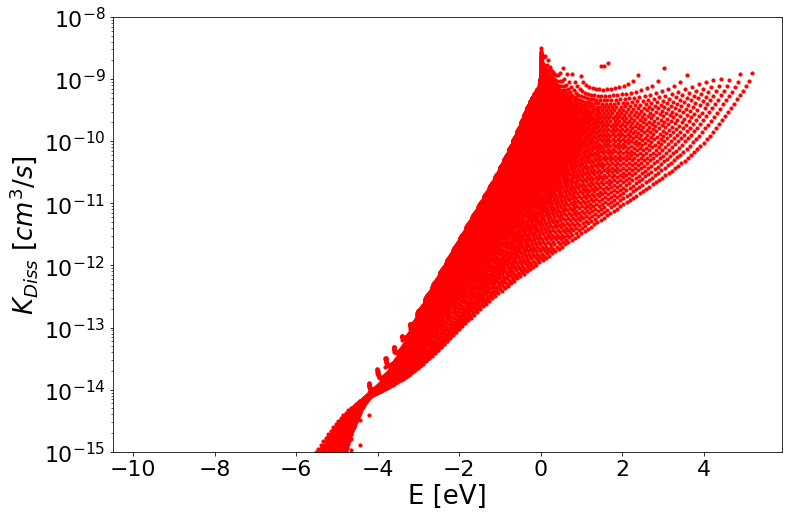

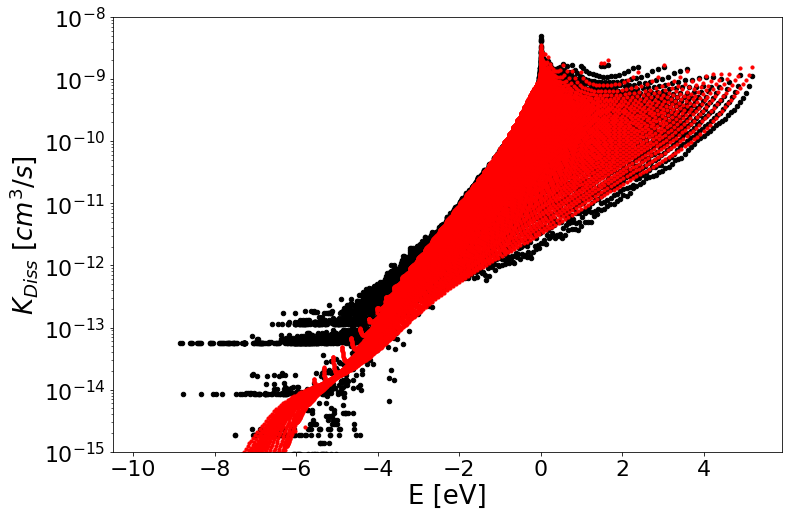

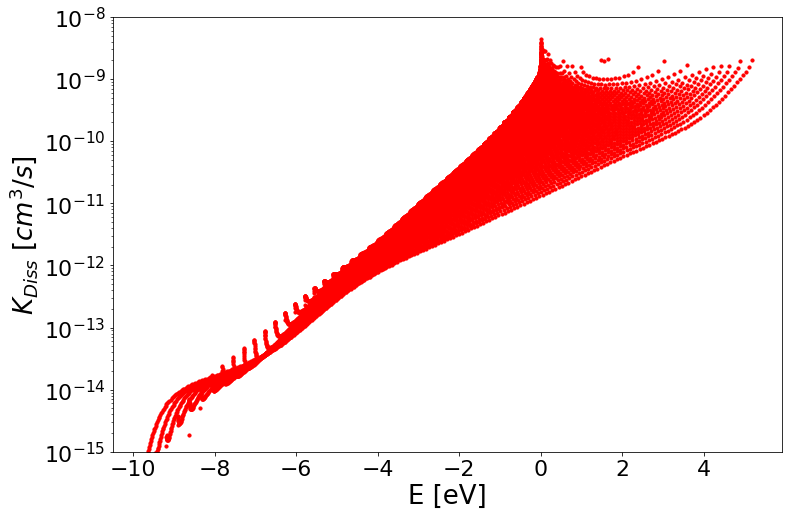

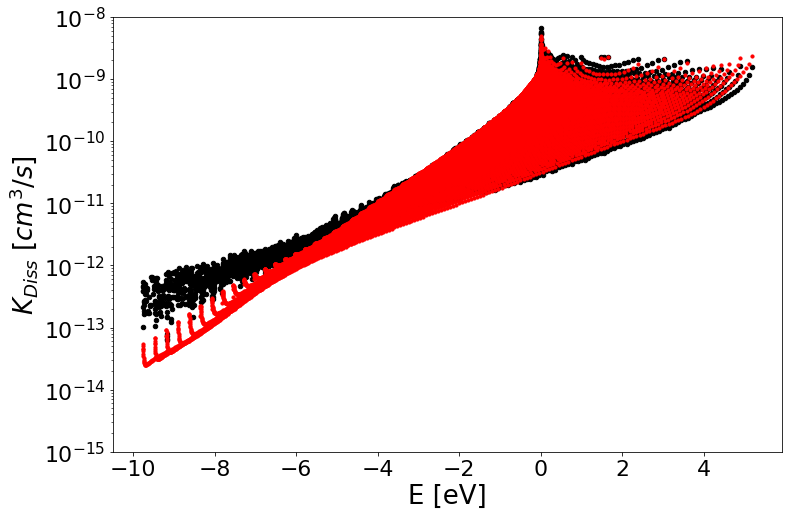

In [12]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    

[SurQCT]:    TTran =  1500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  3000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 3000K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/H

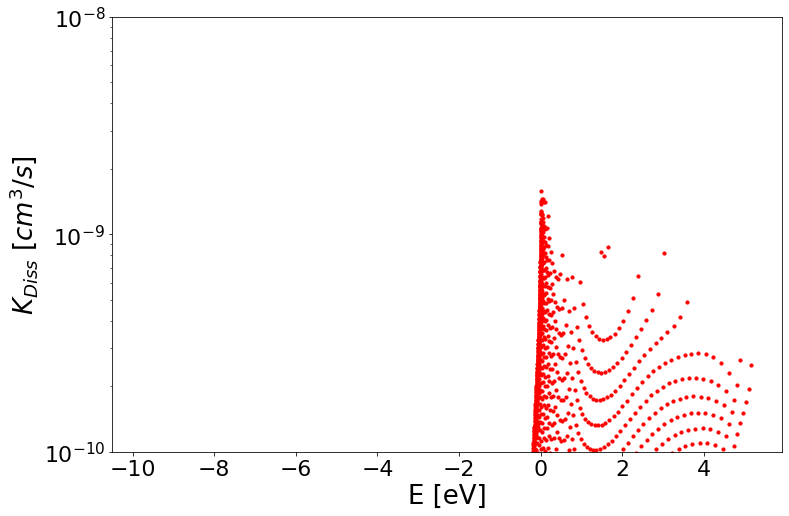

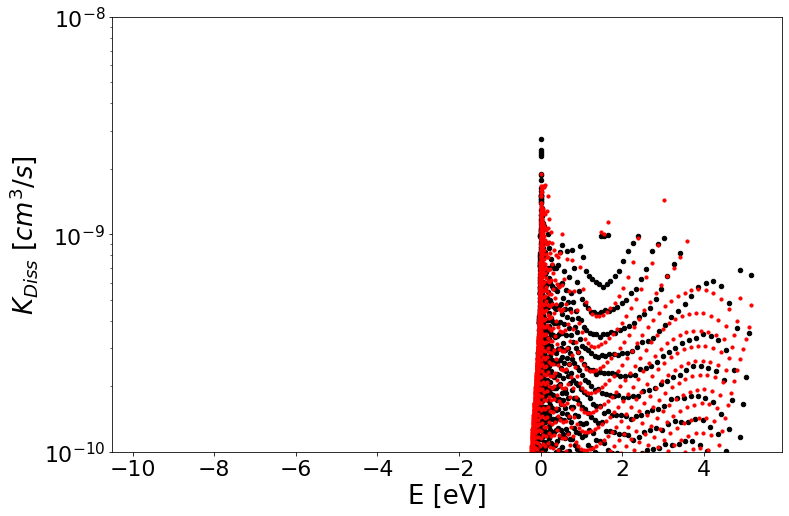

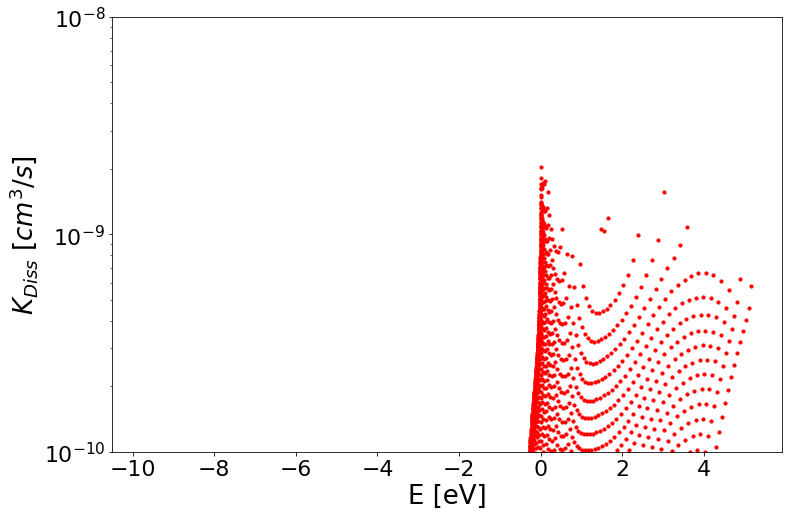

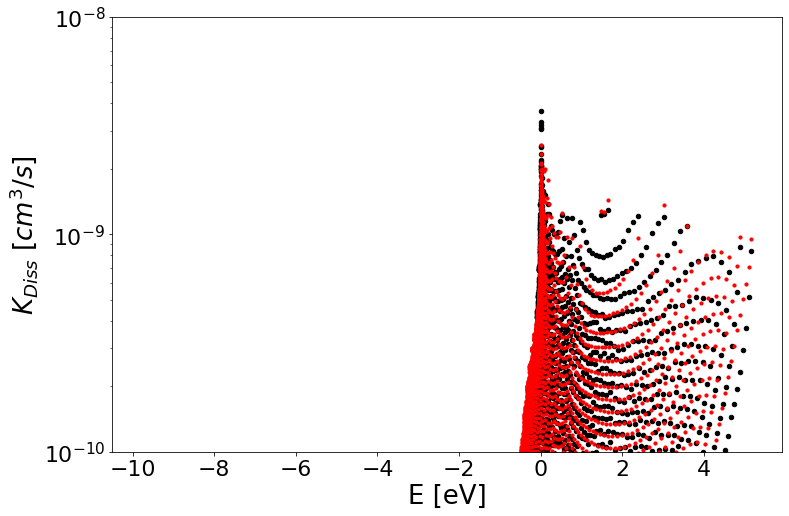

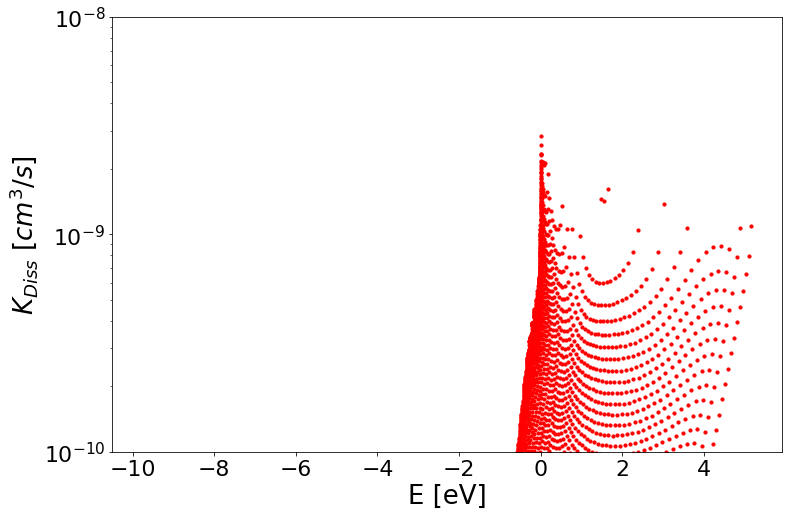

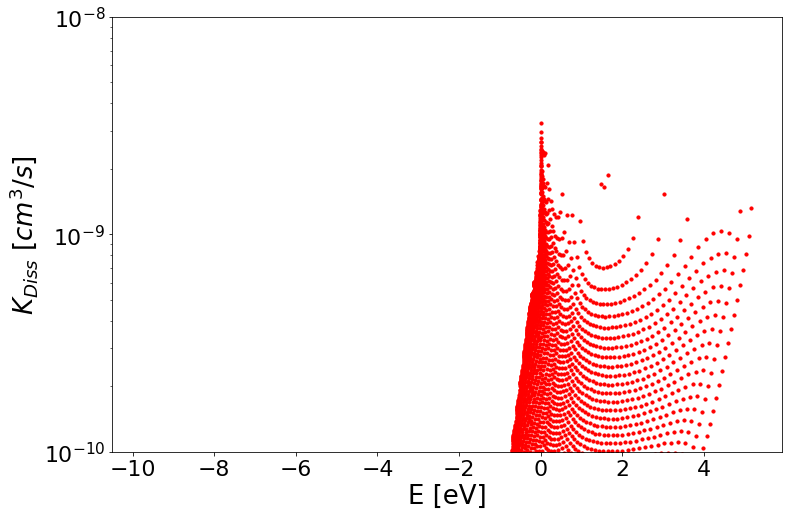

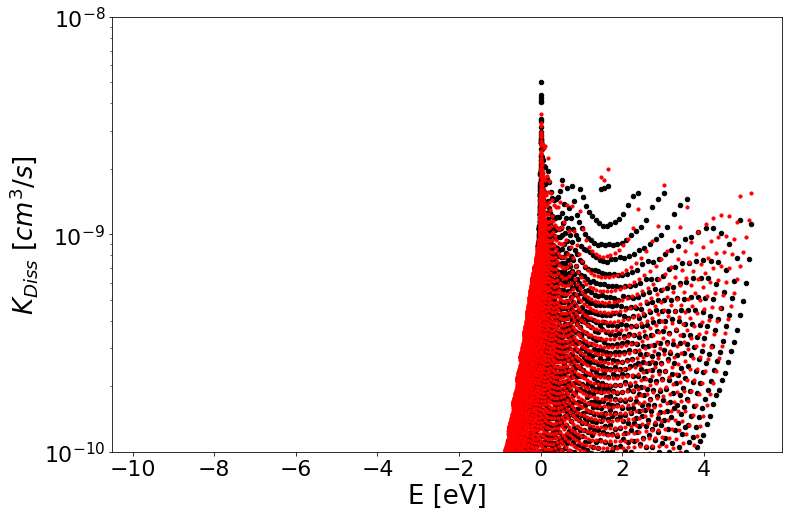

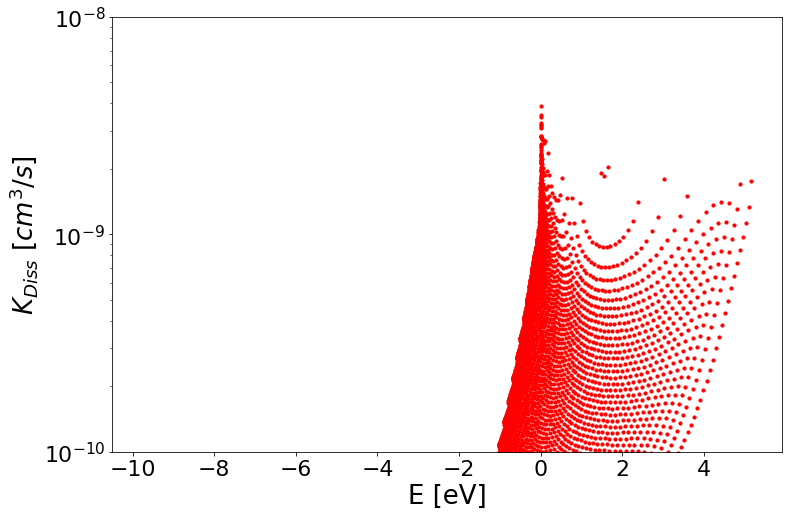

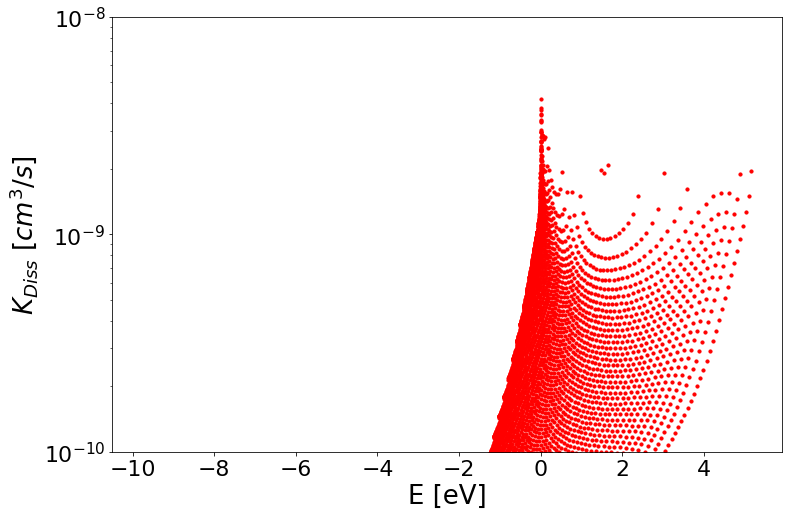

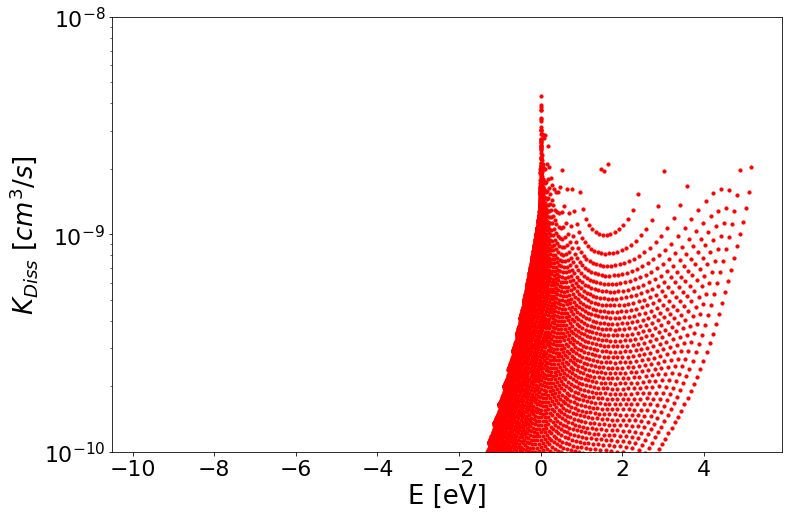

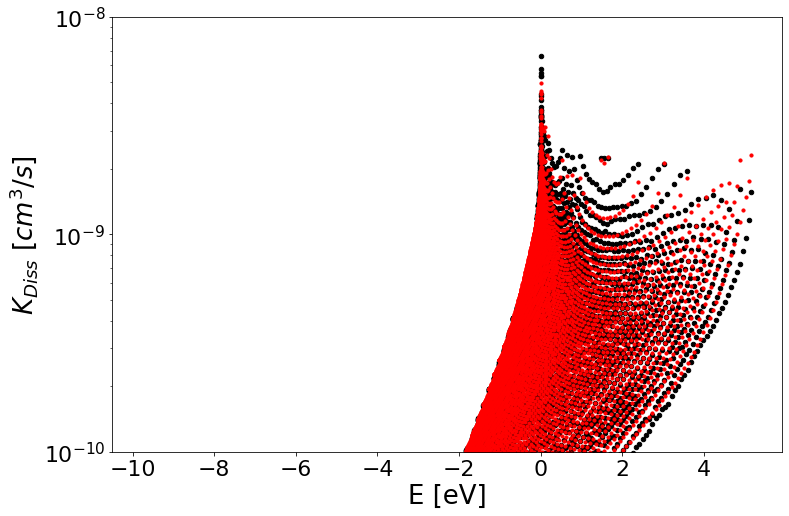

In [19]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-10, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')

In [10]:
PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp']
Molecules        = ['NO', 'NO']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/NON_UMN.hdf5'
ScalingFact      = 1

In [11]:
# #===================================================================================================================================
# ### Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

TTranVec

[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp


[1500.0,
 2500.0,
 3000.0,
 5000.0,
 6000.0,
 8000.0,
 10000.0,
 12000.0,
 14000.0,
 15000.0,
 20000.0]

[SurQCT]:    TTran =  1500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  3000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 3000K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/H

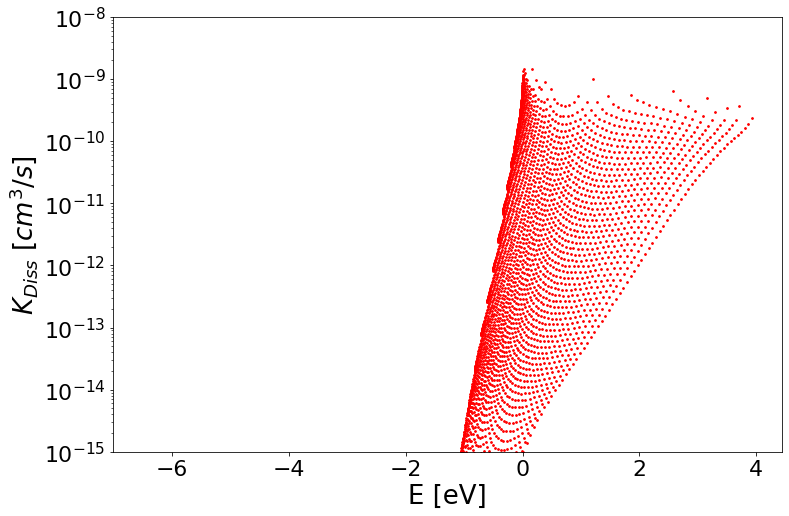

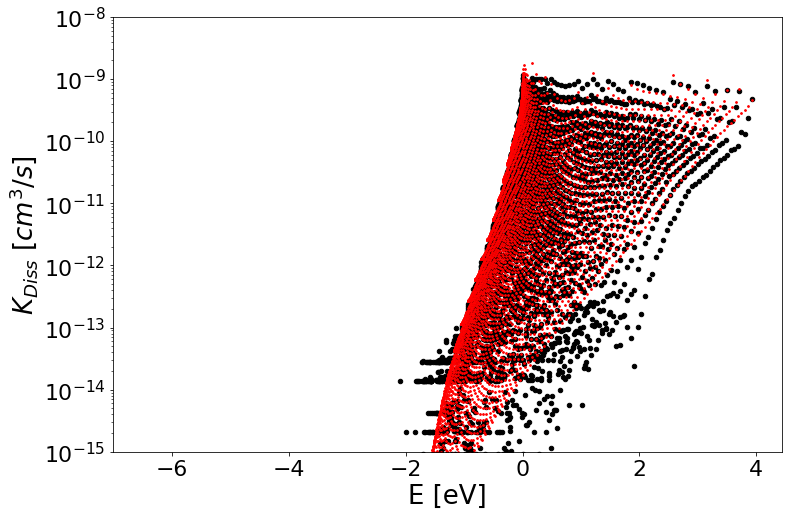

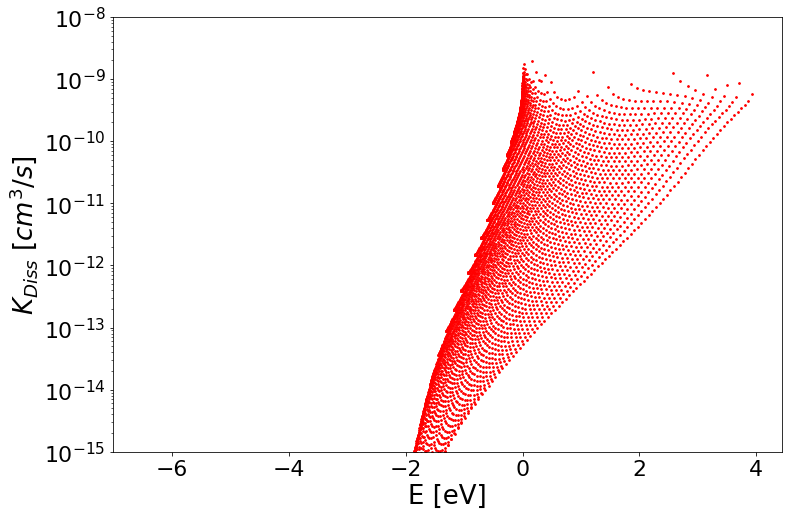

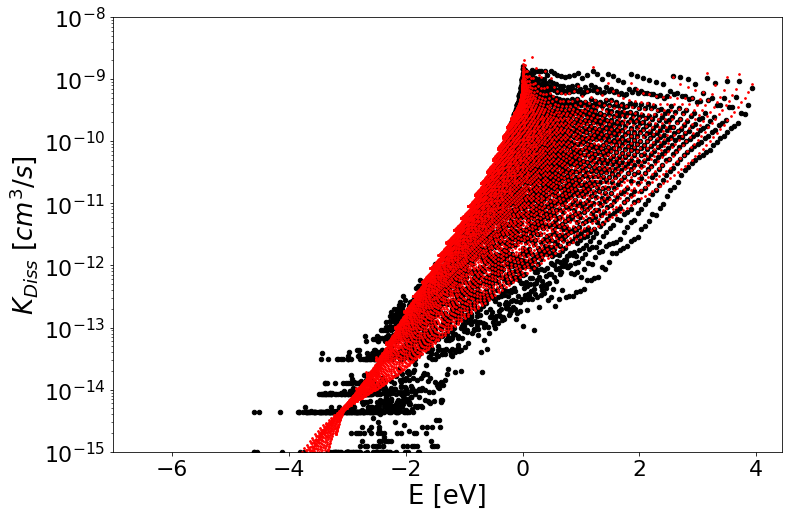

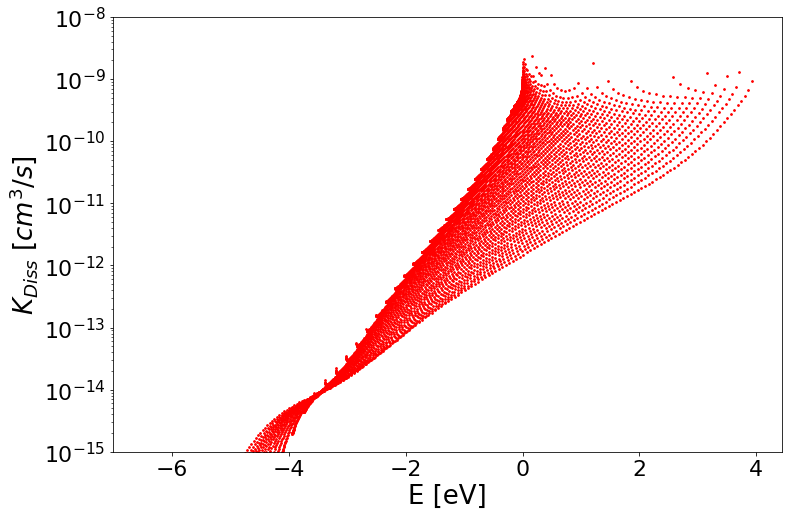

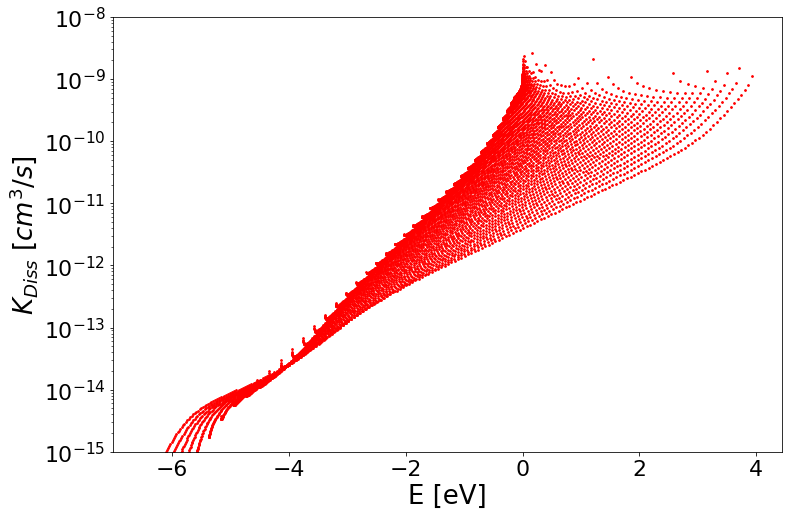

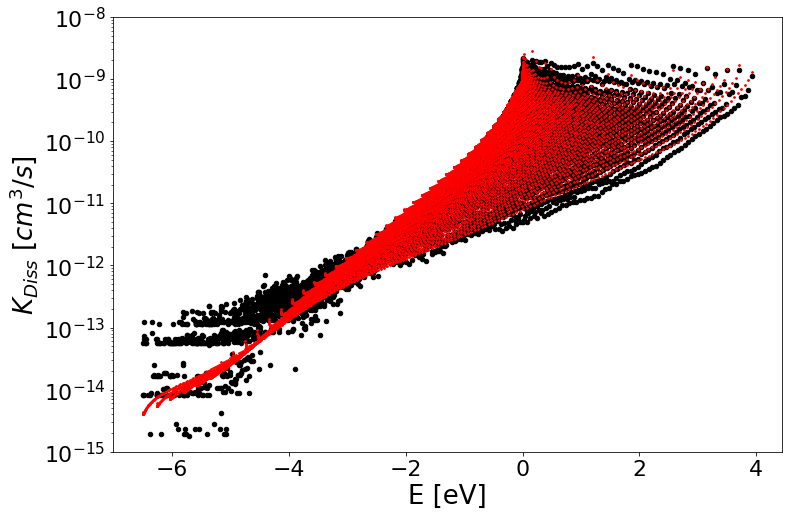

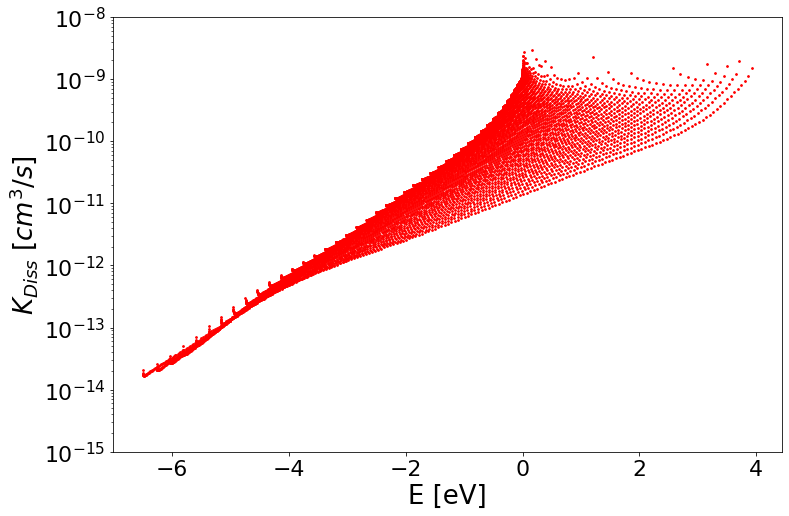

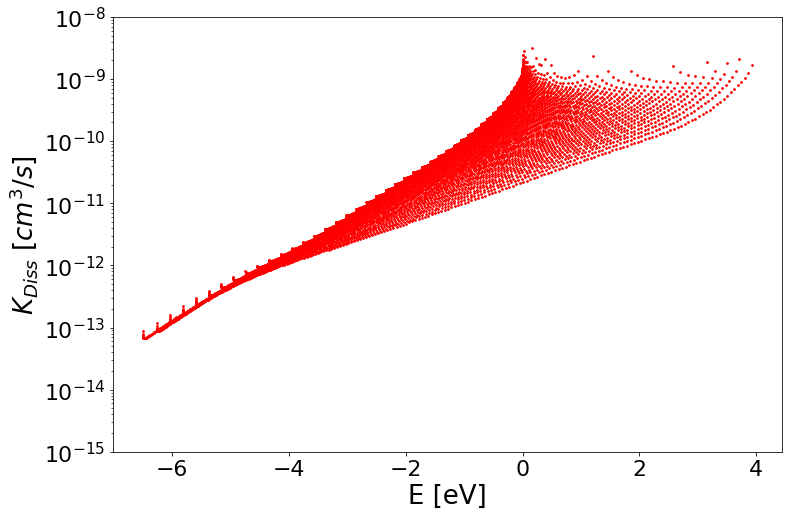

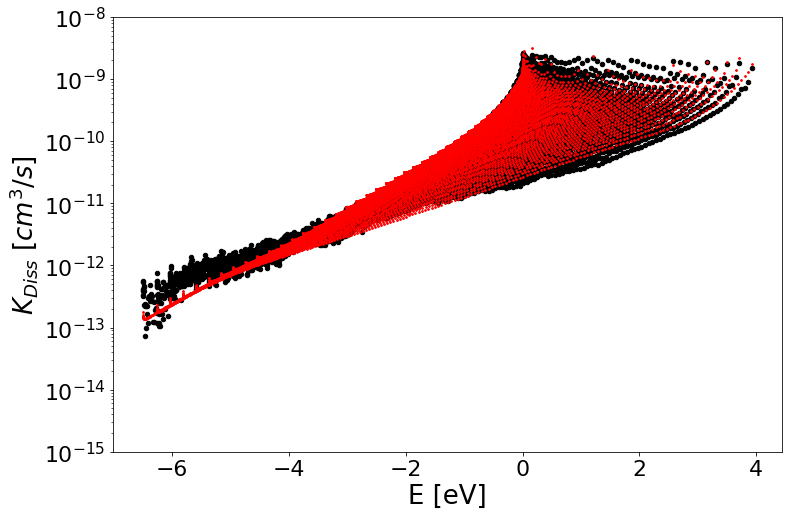

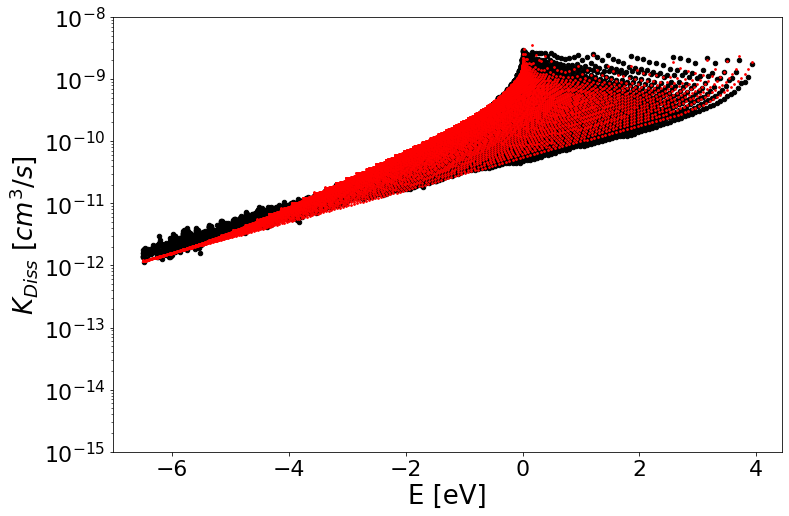

In [12]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=3, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')

[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/N2_UMN_ForN2O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/N2_UMN_ForN2O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N2O_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/N2O_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  7500.0
[SurQCT]:       Reading HDF5 File from: /

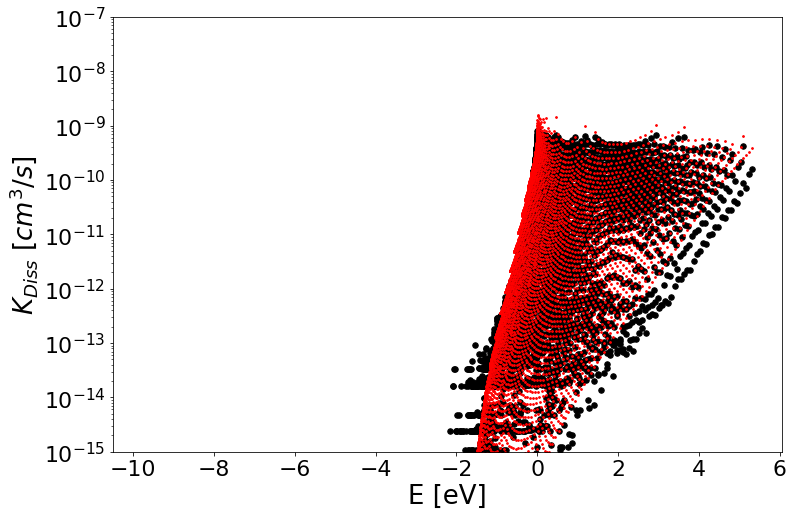

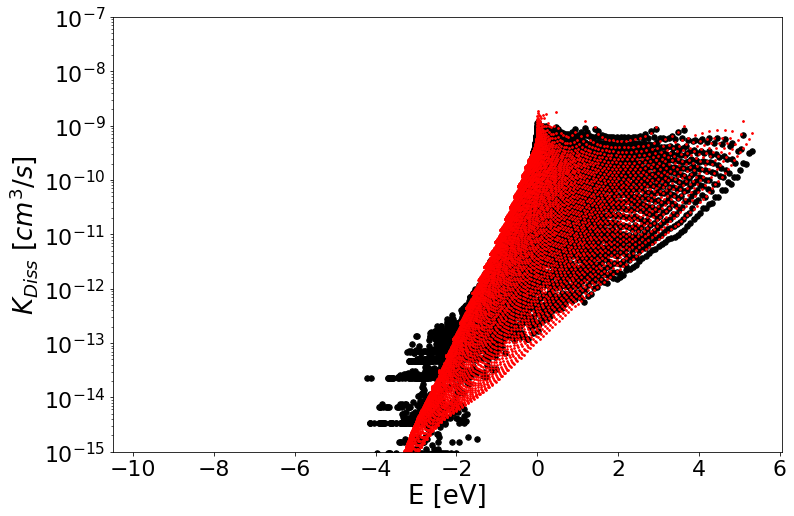

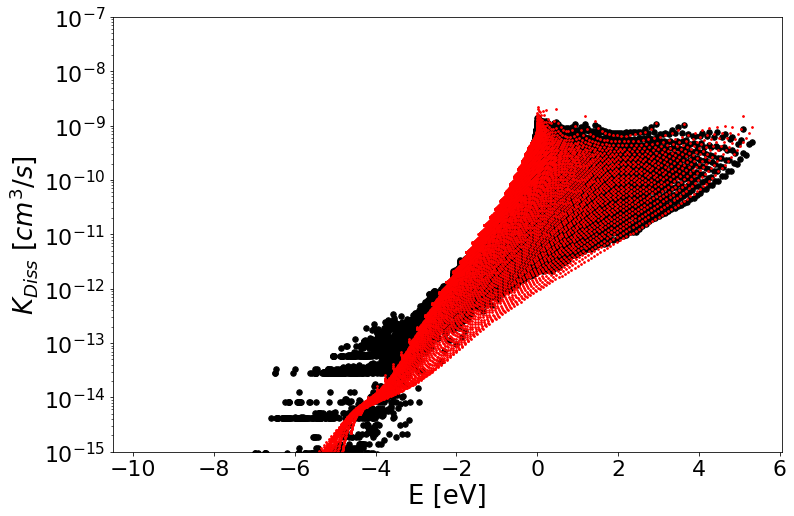

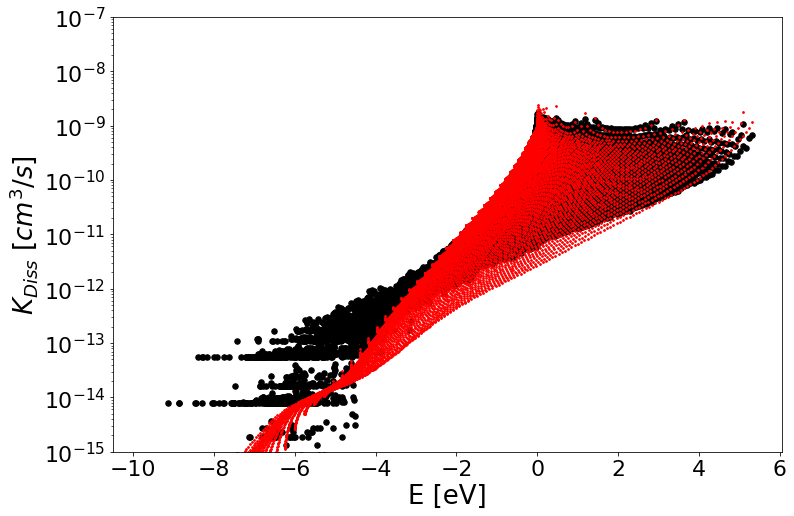

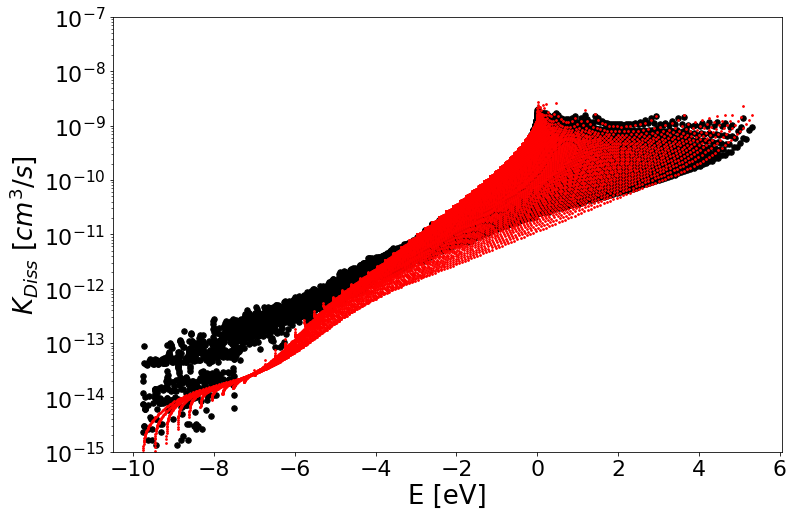

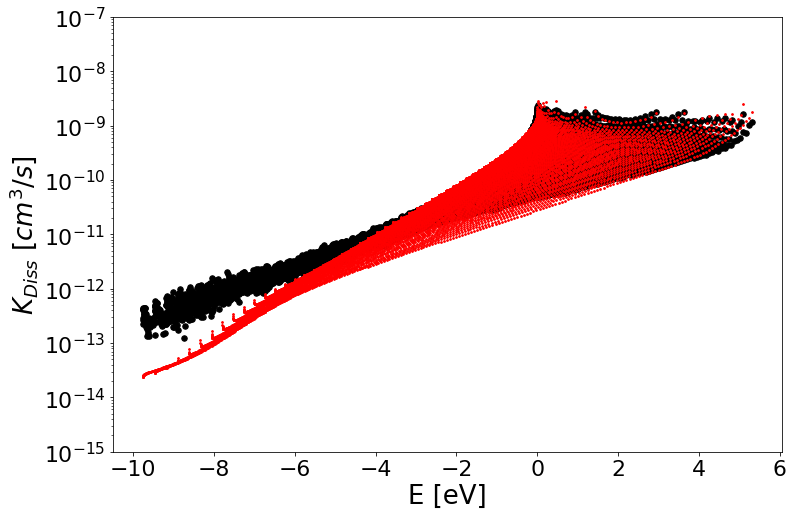

In [19]:
PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_UMN_ForN2O2_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_UMN_ForN2O2_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp']
Molecules        = ['N2', 'N2']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/N2O_UMN.hdf5'
ScalingFact      = 1

# #===================================================================================================================================
# ### Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

TTranVec = [2500.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0]
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=30, c='k')
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,1], s=20, c='b')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=3, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-7])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    

[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/CO_NASA_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/CO/NASA/CO_levels_NASA.dat
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/CO_NASA_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/CO/NASA/CO_levels_NASA.dat
[SurQCT]:    TTran =  2500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/CO2_NASA.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/CO2_NASA.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  7500.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WOR

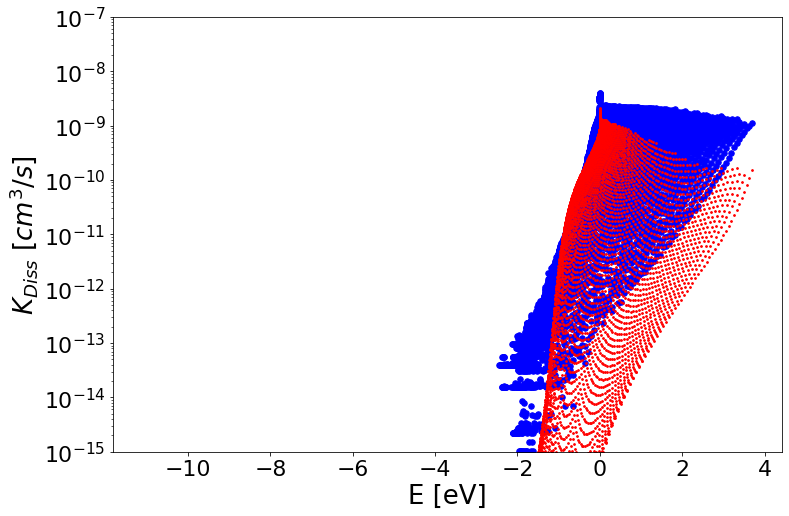

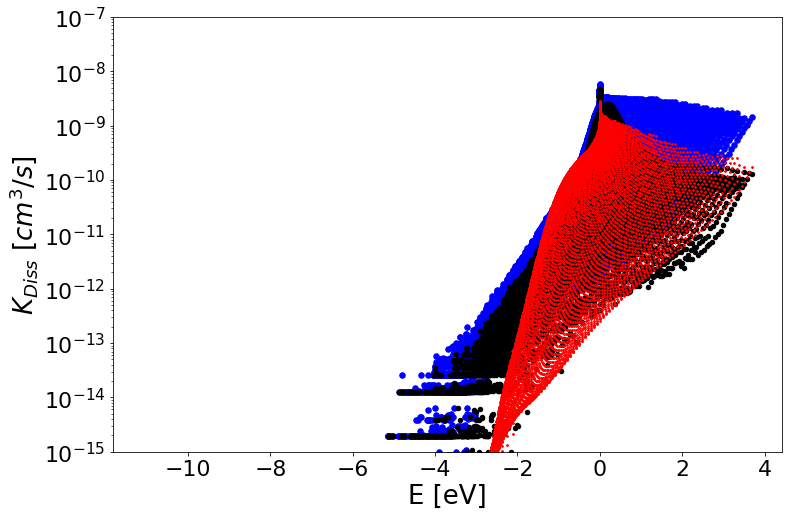

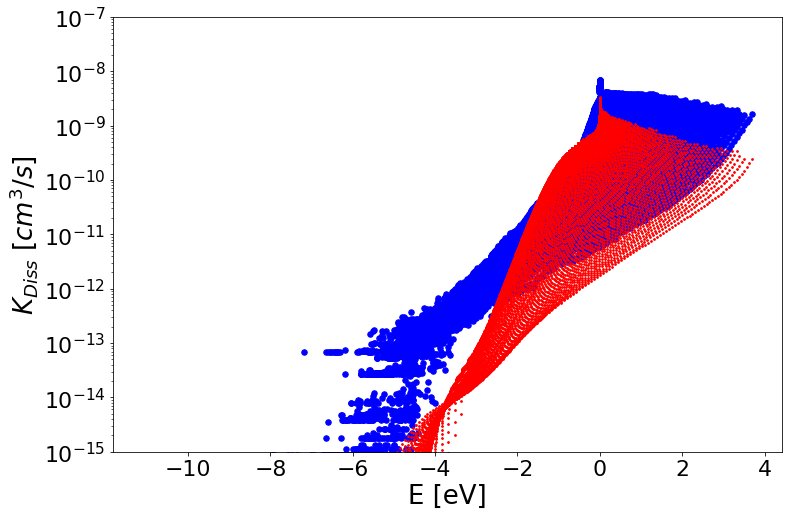

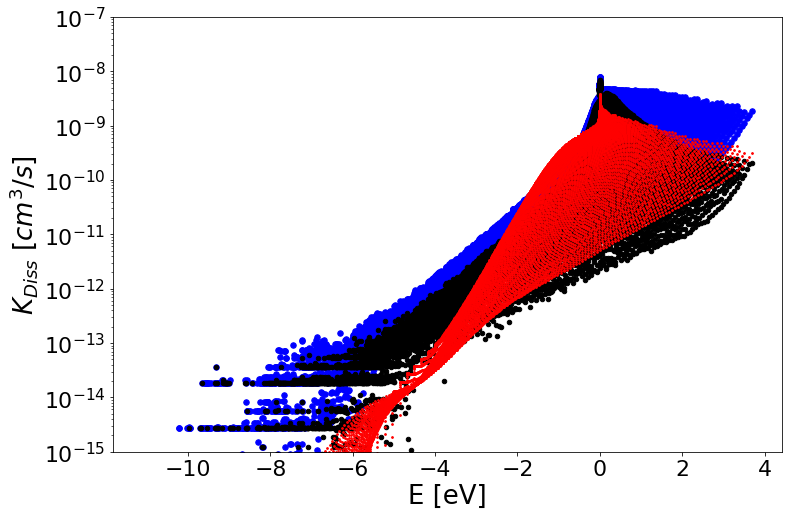

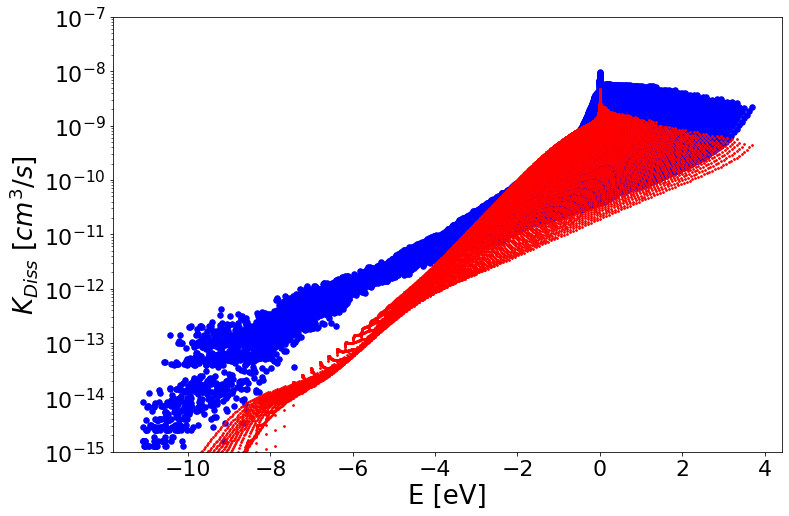

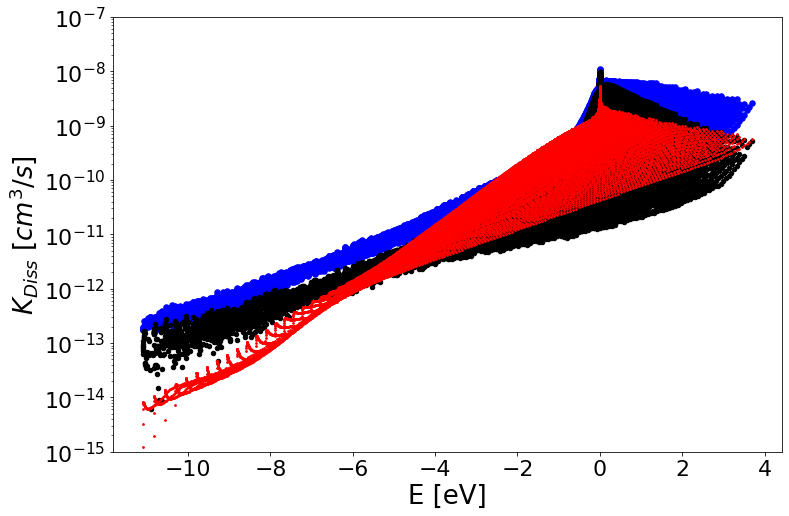

In [14]:
# PathToLevelsFile = InputData.PathToLevelsFile
# PathToDiatFile   = InputData.PathToDiatFile
# Molecules        = InputData.Molecules
# PathToHDF5File   = InputData.PathToHDF5File
# ScalingFact      = 1

PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/CO_NASA_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/CO_NASA_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/CO/NASA/CO_levels_NASA.dat',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/CO/NASA/CO_levels_NASA.dat']
Molecules        = ['CO', 'CO']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/CO2_NASA.hdf5'
ScalingFact      = 1 #16/3

# #===================================================================================================================================
# ### Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

TTranVec = [2500.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0]
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig = plt.figure(figsize=(12,8))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=30, c='b')
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,1], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=3, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-7])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    

[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/O2_NASA_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/NASA/O2_levels_venturi_new.dat
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//Air_Database/Run_0D/database/levels/O2_NASA_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/maitreyee/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/NASA/O2_levels_venturi_new.dat
[SurQCT]:    TTran =  10000.0
[SurQCT]:       Reading HDF5 File from: /home/maitreyee/WORKSPACE//Air_Database/HDF5_Database/O2C_NASA.hdf5 for Excitation Rates at Temperature 10000K


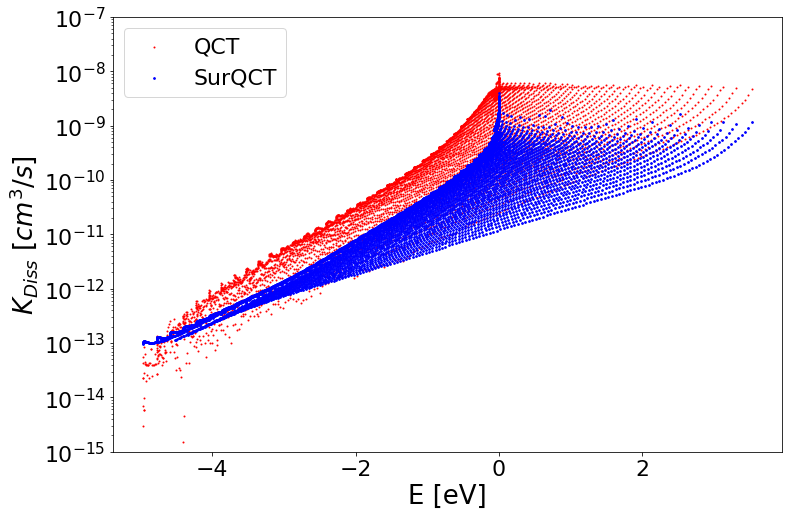

In [14]:
# PathToLevelsFile = InputData.PathToLevelsFile
# PathToDiatFile   = InputData.PathToDiatFile
# Molecules        = InputData.Molecules
# PathToHDF5File   = InputData.PathToHDF5File
# ScalingFact      = 1

fig = plt.figure(figsize=(12,8))
TTranVec = [10000.0]

# for TTran in TTranVec:
#     print('[SurQCT]:    TTran = ', TTran)
    
#     KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
#     jNLevels = len(LevelsData[0])    

#     ### FWD Rates
#     iiIdxVec              = np.arange(jNLevels)

#     TTranVecNlevels       = np.ones((jNLevels))*TTran
#     TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
#     TTranDataTemp.index   = iiIdxVec


#     iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
#     iLevelsDataTemp.index = iiIdxVec

#     iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
#     iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

#     KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
#     ### Plotting

#     if (KDissAll is not None):
#         plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=30, c='k')
# #     plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
#     plt.yscale('log')
#     plt.ylim([1.e-15, 1.e-8])
#     plt.xlabel('E [eV]')
#     plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    
PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/O2_NASA_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/O2_NASA_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/NASA/O2_levels_venturi_new.dat',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/NASA/O2_levels_venturi_new.dat']
Molecules        = ['O2', 'O2']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/O2C_NASA.hdf5'
ScalingFact      = 1 #16/3

# #===================================================================================================================================
# ### Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=1, c='r')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=3, c='b')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-7])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    plt.legend(['QCT','SurQCT'])
    